In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Radial velocity fitting

In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

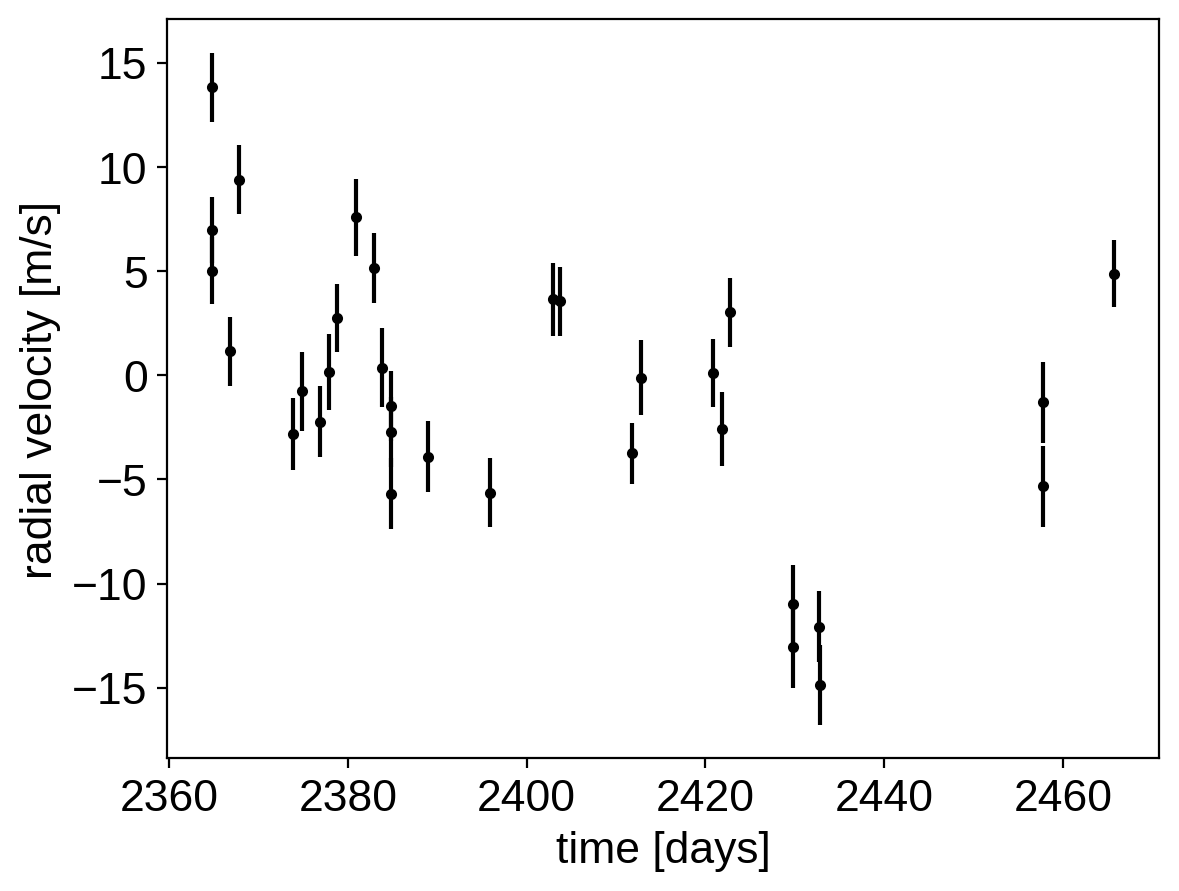

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x.min() + x.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Bound(pm.Normal, lower=0)(
        "P",
        mu=np.array(periods),
        sd=np.array(period_errs),
        shape=2,
        testval=np.array(periods),
    )

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)(
        "logK", mu=np.log(Ks), sd=10.0, shape=2, testval=np.log(Ks)
    )

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform(
        "ecc", shape=2, testval=np.array([0.1, 0.1])
    )
    omega = xo.distributions.Angle("omega", shape=2)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 3)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

Now, we can plot the initial model:

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


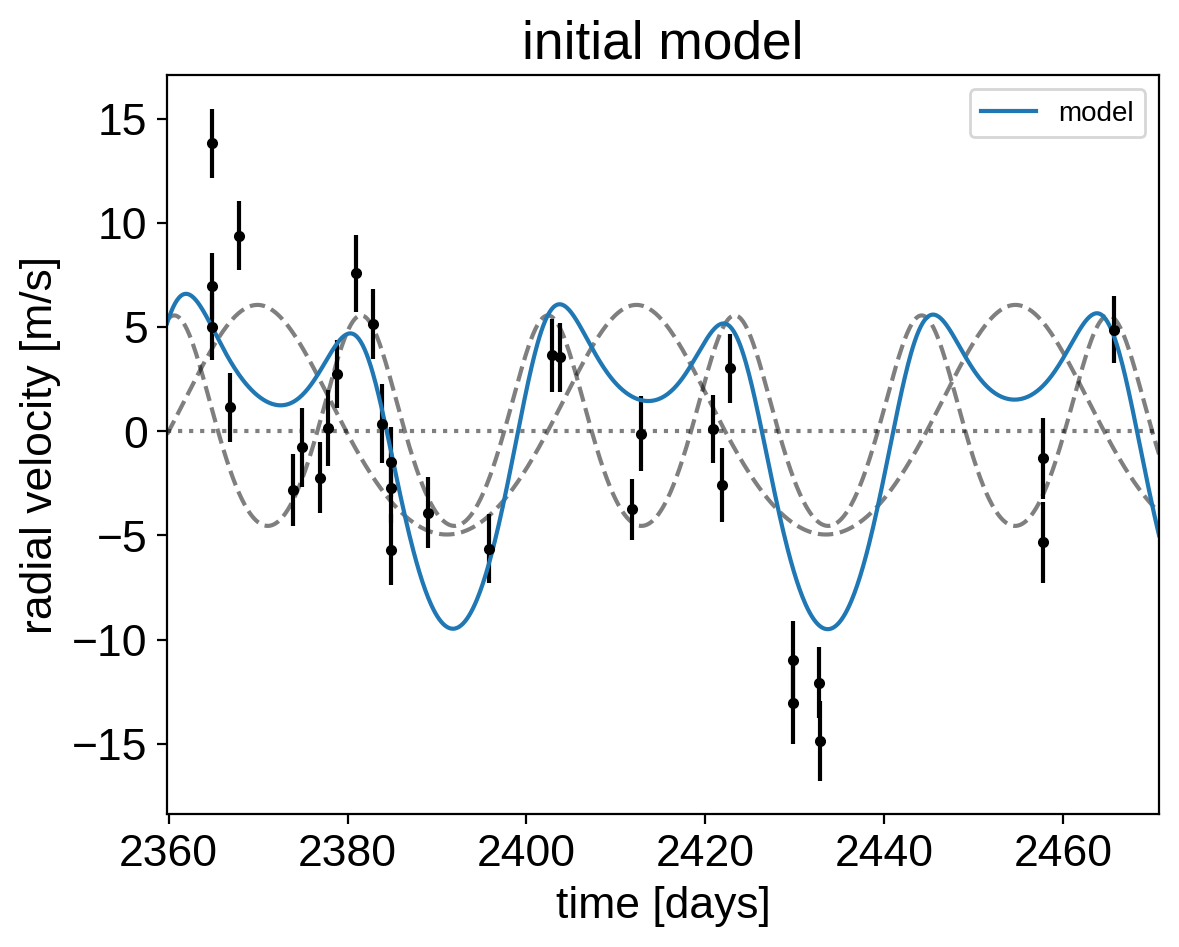

In [6]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's fit for the maximum a posterior parameters.

In [7]:
with model:
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-7.973266e+01]

1it [00:00, 523.63it/s, logp=-7.973266e+01]

2it [00:00, 626.58it/s, logp=-5.305392e+06]

3it [00:00, 671.09it/s, logp=-7.966783e+01]

4it [00:00, 693.70it/s, logp=-7.953812e+01]

5it [00:00, 730.41it/s, logp=-7.904438e+01]

6it [00:00, 752.41it/s, logp=-7.747076e+01]

7it [00:00, 756.82it/s, logp=-7.344108e+01]

8it [00:00, 777.19it/s, logp=-6.722892e+01]

9it [00:00, 800.20it/s, logp=-6.484820e+01]

10it [00:00, 779.68it/s, logp=-6.484820e+01]

11it [00:00, 801.97it/s, logp=-6.484820e+01]

12it [00:03,  3.67it/s, logp=-6.484820e+01] 


message: Optimization terminated successfully.
logp: -79.73266285618838 -> -64.8482026233154


optimizing logp for variables: [trend, logs, omega, ecc, logK, P, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.484820e+01]

1it [00:00, 359.72it/s, logp=-6.484820e+01]

2it [00:00, 415.65it/s, logp=-4.990134e+09]

3it [00:00, 433.97it/s, logp=-6.484832e+01]

4it [00:00, 502.25it/s, logp=-6.484777e+01]

5it [00:00, 538.96it/s, logp=-6.519268e+01]

6it [00:00, 582.88it/s, logp=-6.484777e+01]

7it [00:00, 602.95it/s, logp=-6.484777e+01]

8it [00:00, 637.31it/s, logp=-6.484776e+01]

9it [00:00, 663.54it/s, logp=-6.484774e+01]

10it [00:00, 688.19it/s, logp=-6.484767e+01]

11it [00:00, 696.83it/s, logp=-6.484739e+01]

12it [00:00, 707.32it/s, logp=-6.484633e+01]

13it [00:00, 718.38it/s, logp=-6.484353e+01]

14it [00:00, 731.86it/s, logp=-6.483426e+01]

15it [00:00, 737.08it/s, logp=-6.481055e+01]

16it [00:00, 750.79it/s, logp=-6.472940e+01]

17it [00:00, 750.00it/s, logp=-6.451928e+01]

18it [00:00, 760.26it/s, logp=-6.371170e+01]

19it [00:00, 747.56it/s, logp=-6.096678e+01]

20it [00:00, 746.31it/s, logp=-5.708652e+01]

21it [00:00, 749.77it/s, logp=-5.027536e+01]

22it [00:00, 753.93it/s, logp=-2.386568e+02]

23it [00:00, 761.08it/s, logp=-4.912172e+01]

24it [00:00, 755.40it/s, logp=-4.707357e+01]

25it [00:00, 757.23it/s, logp=-4.319328e+01]

26it [00:00, 755.85it/s, logp=-3.608487e+01]

27it [00:00, 758.56it/s, logp=-2.498567e+01]

28it [00:00, 754.87it/s, logp=-2.442071e+01]

29it [00:00, 754.28it/s, logp=-2.333036e+01]

30it [00:00, 759.38it/s, logp=-2.011091e+01]

31it [00:00, 762.16it/s, logp=-1.751350e+01]

32it [00:00, 758.39it/s, logp=-1.714559e+01]

33it [00:00, 758.61it/s, logp=-1.693796e+01]

34it [00:00, 761.17it/s, logp=-1.684943e+01]

35it [00:00, 757.45it/s, logp=-1.676095e+01]

36it [00:00, 760.37it/s, logp=-1.673569e+01]

37it [00:00, 762.33it/s, logp=-1.672214e+01]

38it [00:00, 758.83it/s, logp=-1.670758e+01]

39it [00:00, 758.99it/s, logp=-1.668064e+01]

40it [00:00, 759.73it/s, logp=-1.662858e+01]

41it [00:00, 763.69it/s, logp=-1.658058e+01]

42it [00:00, 768.25it/s, logp=-1.655728e+01]

43it [00:00, 770.01it/s, logp=-1.662929e+01]

44it [00:00, 775.09it/s, logp=-1.647872e+01]

45it [00:00, 776.19it/s, logp=-1.635178e+01]

46it [00:00, 777.58it/s, logp=-1.613280e+01]

47it [00:00, 768.42it/s, logp=-1.577352e+01]

48it [00:00, 767.72it/s, logp=-1.525205e+01]

49it [00:00, 769.29it/s, logp=-1.849895e+01]

50it [00:00, 772.67it/s, logp=-1.514689e+01]

51it [00:00, 769.42it/s, logp=-1.501721e+01]

52it [00:00, 769.90it/s, logp=-1.496658e+01]

53it [00:00, 770.19it/s, logp=-1.495457e+01]

54it [00:00, 772.22it/s, logp=-1.494704e+01]

55it [00:00, 773.20it/s, logp=-1.494509e+01]

56it [00:00, 774.59it/s, logp=-1.494181e+01]

57it [00:00, 775.82it/s, logp=-1.493619e+01]

58it [00:00, 777.16it/s, logp=-1.492655e+01]

59it [00:00, 778.25it/s, logp=-1.491151e+01]

60it [00:00, 771.30it/s, logp=-1.489345e+01]

61it [00:00, 773.16it/s, logp=-1.486580e+01]

62it [00:00, 771.53it/s, logp=-1.483881e+01]

63it [00:00, 771.59it/s, logp=-1.479783e+01]

64it [00:00, 771.35it/s, logp=-1.475797e+01]

65it [00:00, 772.70it/s, logp=-1.470224e+01]

66it [00:00, 773.13it/s, logp=-1.466581e+01]

67it [00:00, 776.45it/s, logp=-1.465792e+01]

68it [00:00, 777.06it/s, logp=-1.460984e+01]

69it [00:00, 772.99it/s, logp=-1.453216e+01]

70it [00:00, 773.66it/s, logp=-1.441150e+01]

71it [00:00, 773.80it/s, logp=-1.431230e+01]

72it [00:00, 774.50it/s, logp=-1.436794e+01]

73it [00:00, 774.85it/s, logp=-1.429690e+01]

74it [00:00, 775.47it/s, logp=-1.428194e+01]

75it [00:00, 774.91it/s, logp=-1.427769e+01]

76it [00:00, 775.85it/s, logp=-1.427703e+01]

77it [00:00, 774.74it/s, logp=-1.427688e+01]

78it [00:00, 774.04it/s, logp=-1.427678e+01]

79it [00:00, 780.48it/s, logp=-1.427678e+01]

79it [00:00, 780.48it/s, logp=-1.427677e+01]

80it [00:00, 780.48it/s, logp=-1.427676e+01]

81it [00:00, 780.48it/s, logp=-1.427676e+01]

82it [00:00, 780.48it/s, logp=-1.427676e+01]

83it [00:00, 780.48it/s, logp=-1.427676e+01]

84it [00:00, 780.48it/s, logp=-1.427676e+01]

85it [00:00, 780.48it/s, logp=-1.427676e+01]

86it [00:00, 780.48it/s, logp=-1.427676e+01]

87it [00:00, 780.48it/s, logp=-1.427676e+01]

88it [00:00, 780.48it/s, logp=-1.427676e+01]

89it [00:00, 780.48it/s, logp=-1.427676e+01]

90it [00:00, 780.48it/s, logp=-1.427676e+01]

91it [00:00, 780.48it/s, logp=-1.427676e+01]

92it [00:00, 157.32it/s, logp=-1.427676e+01]


message: Optimization terminated successfully.
logp: -64.8482026233154 -> -14.276760262380932


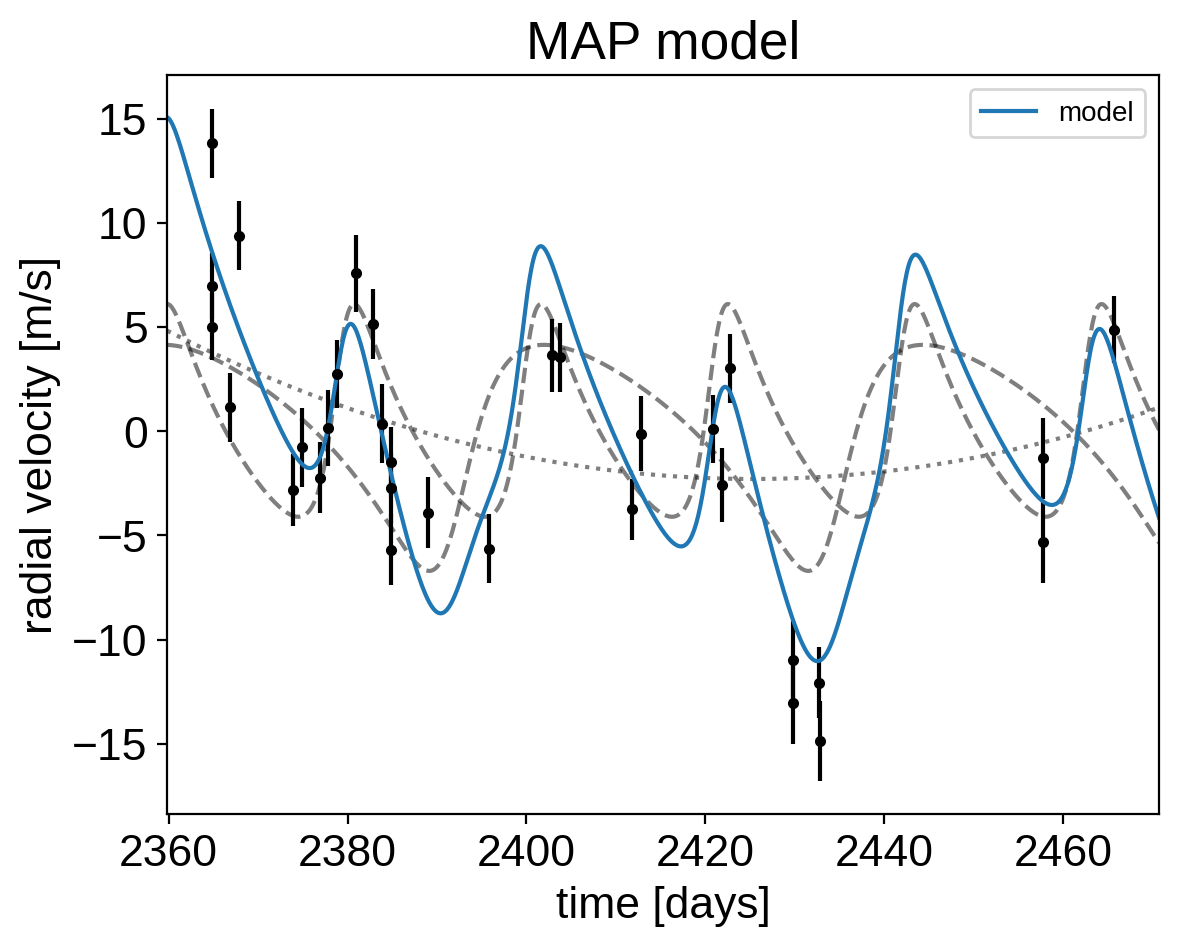

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :func:`exoplanet.get_dense_nuts_step` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [9]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=4000,
        draws=4000,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.95),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 92 seconds.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [10]:
pm.summary(
    trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
trend[0],0.001,0.001,-0.000,0.002,0.000,0.000,4686.0,4527.0,4707.0,4543.0,1.0
trend[1],-0.039,0.022,-0.081,0.002,0.000,0.000,7269.0,6262.0,7269.0,5241.0,1.0
trend[2],-1.956,0.813,-3.512,-0.506,0.014,0.010,3380.0,3380.0,3844.0,2098.0,1.0
logs,1.041,0.223,0.619,1.459,0.005,0.003,2402.0,2213.0,2351.0,2433.0,1.0
omega[0],-0.262,0.813,-1.421,1.423,0.020,0.021,1668.0,779.0,2185.0,1202.0,1.0
omega[1],-0.630,2.121,-3.112,2.900,0.039,0.028,3021.0,2876.0,4359.0,6547.0,1.0
ecc[0],0.236,0.114,0.001,0.418,0.002,0.002,2512.0,2512.0,2157.0,1378.0,1.0
ecc[1],0.201,0.150,0.000,0.472,0.004,0.003,1399.0,936.0,1789.0,1587.0,1.0
t0[0],2072.795,0.001,2072.793,2072.796,0.000,0.000,8450.0,8450.0,8491.0,5159.0,1.0
t0[1],2082.625,0.000,2082.624,2082.626,0.000,0.000,8501.0,8501.0,8516.0,5309.0,1.0


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

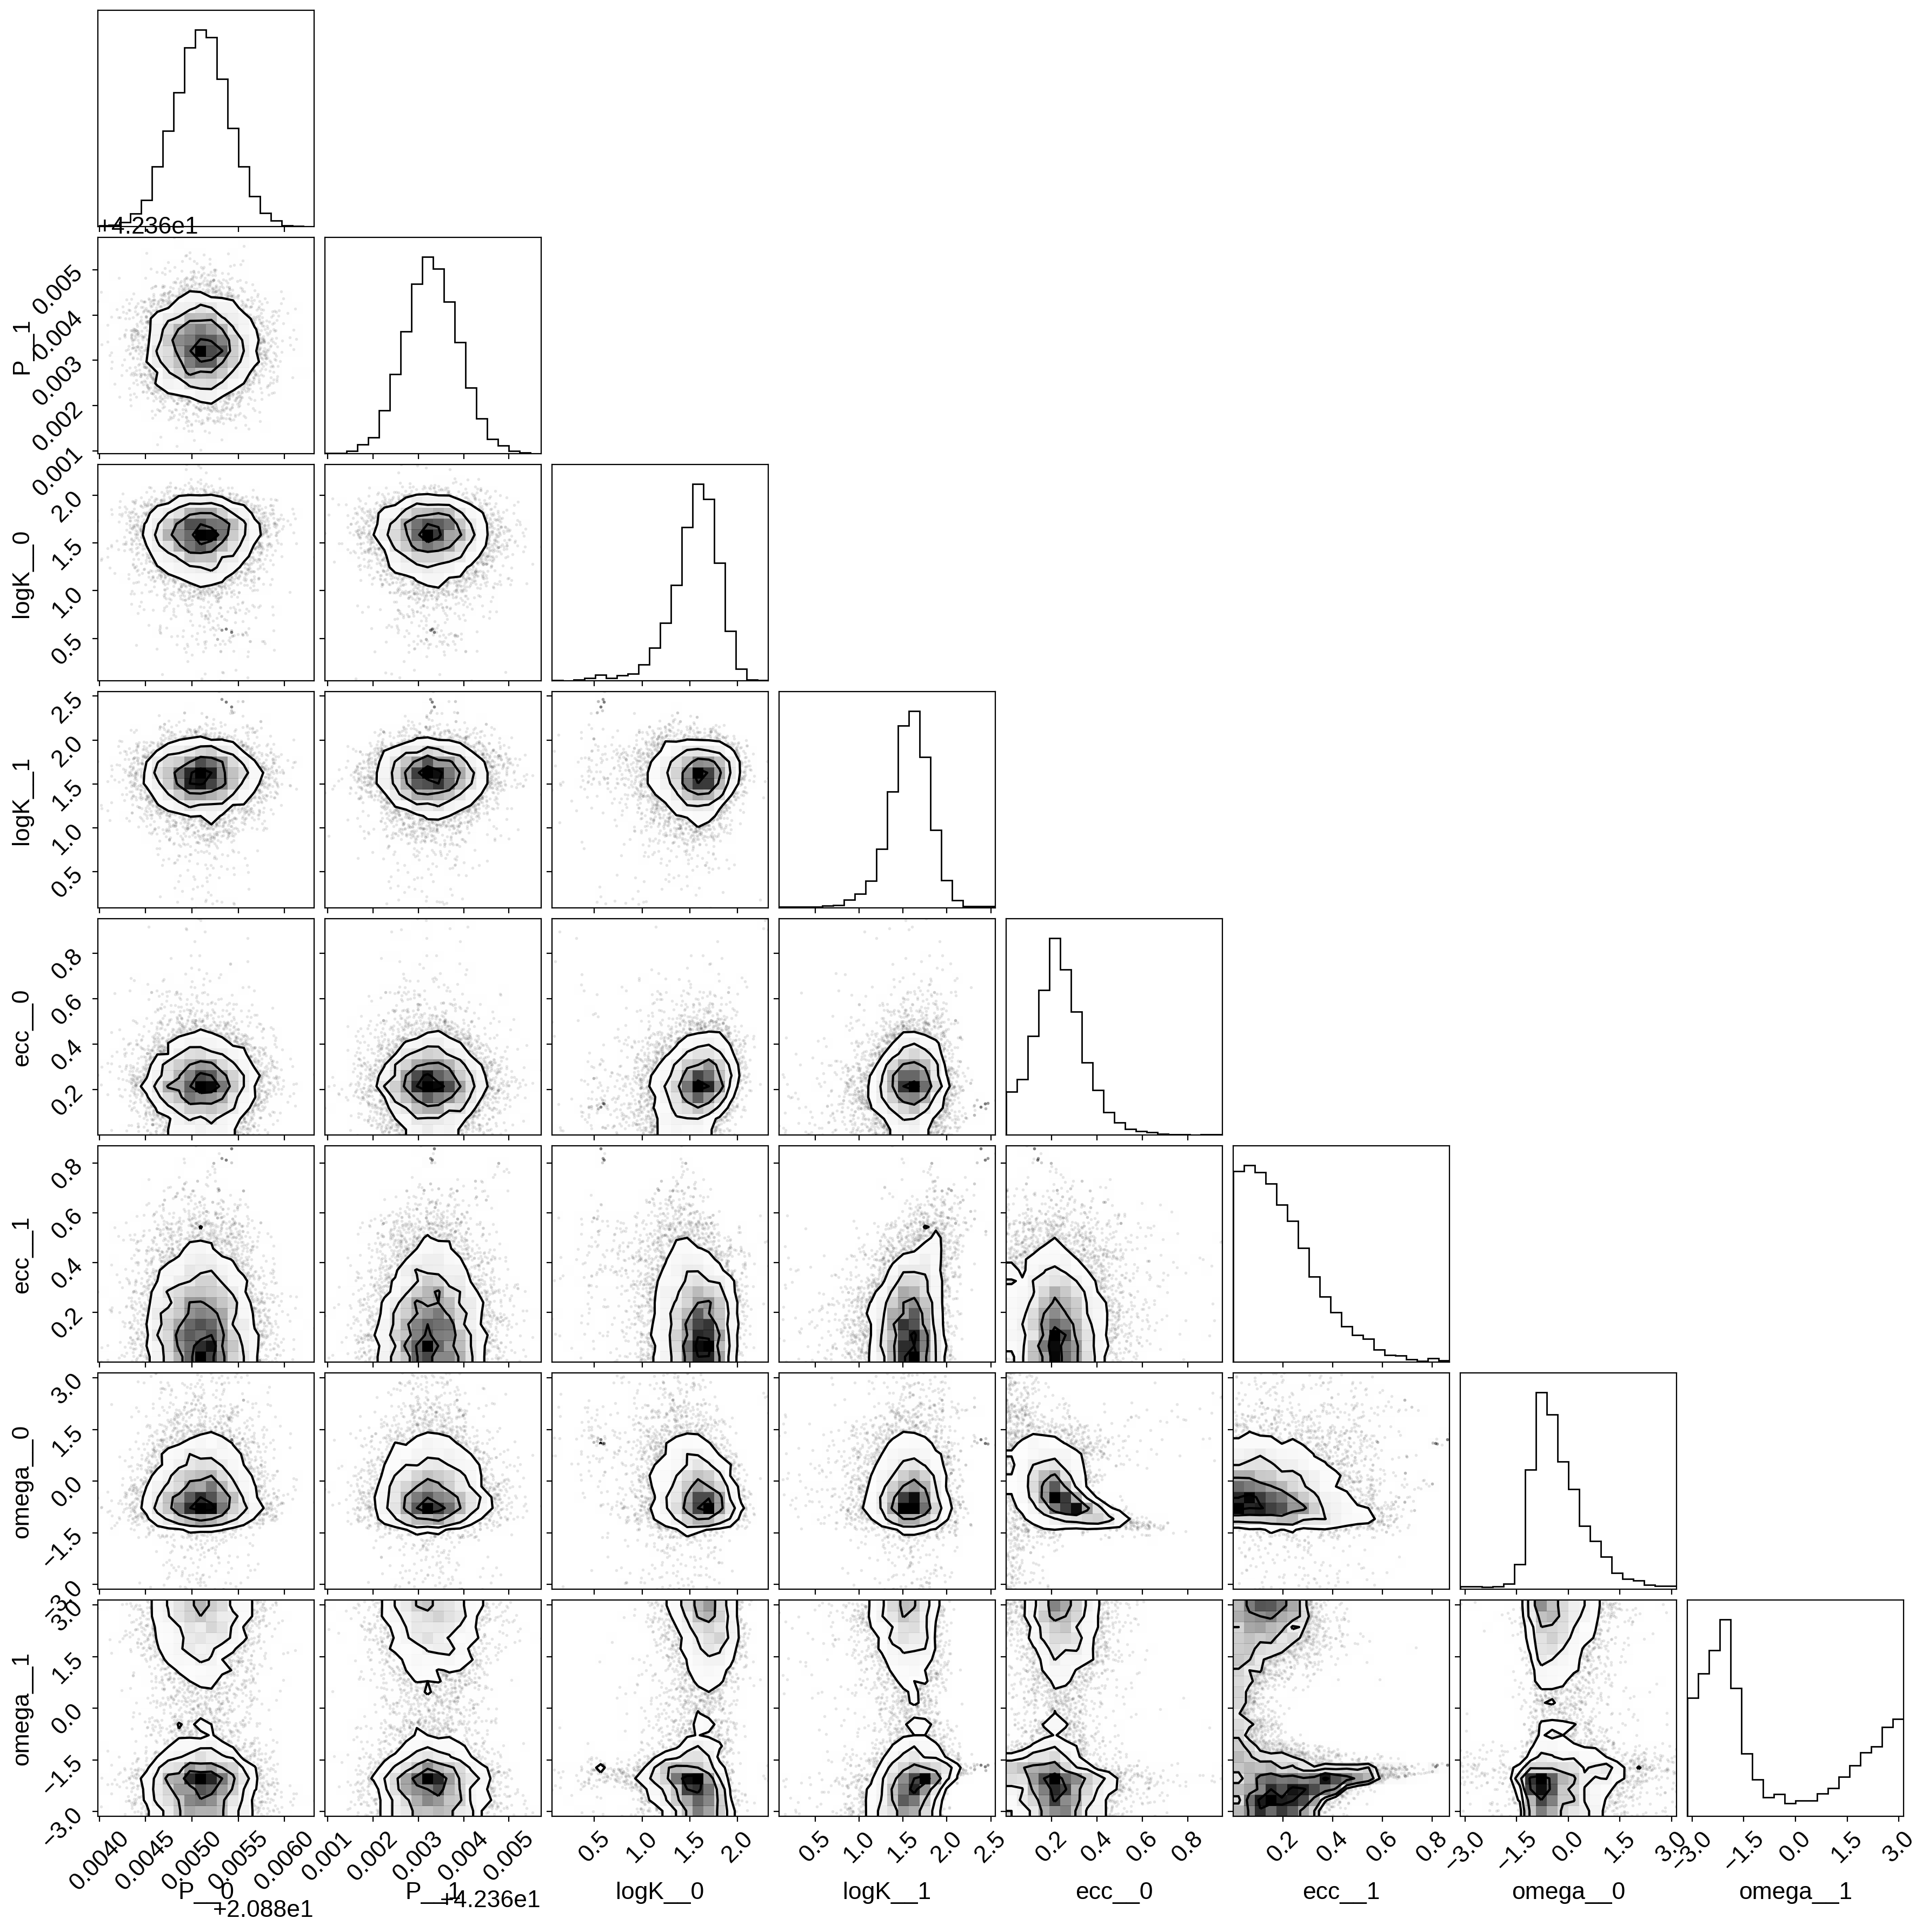

In [11]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc", "omega"])
_ = corner.corner(samples)

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

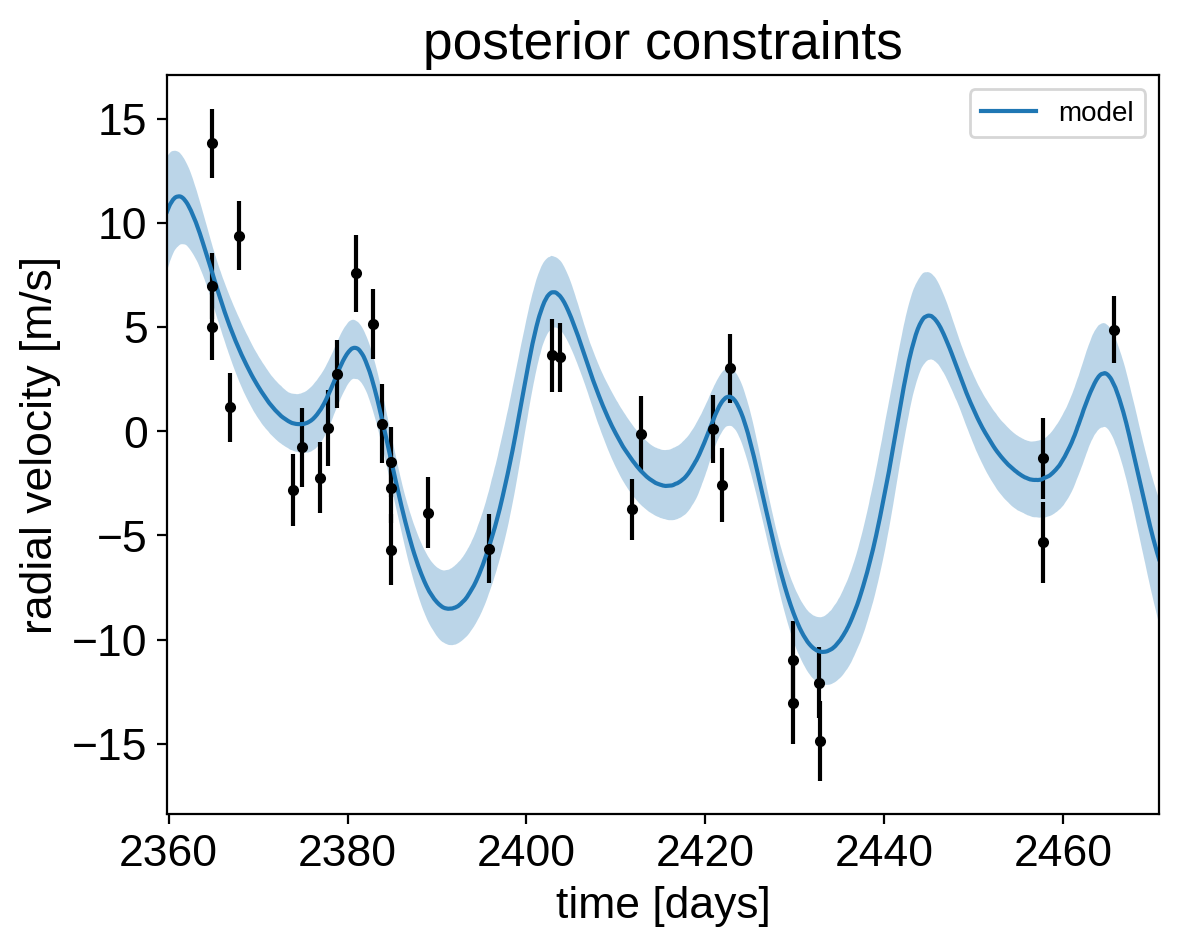

In [12]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

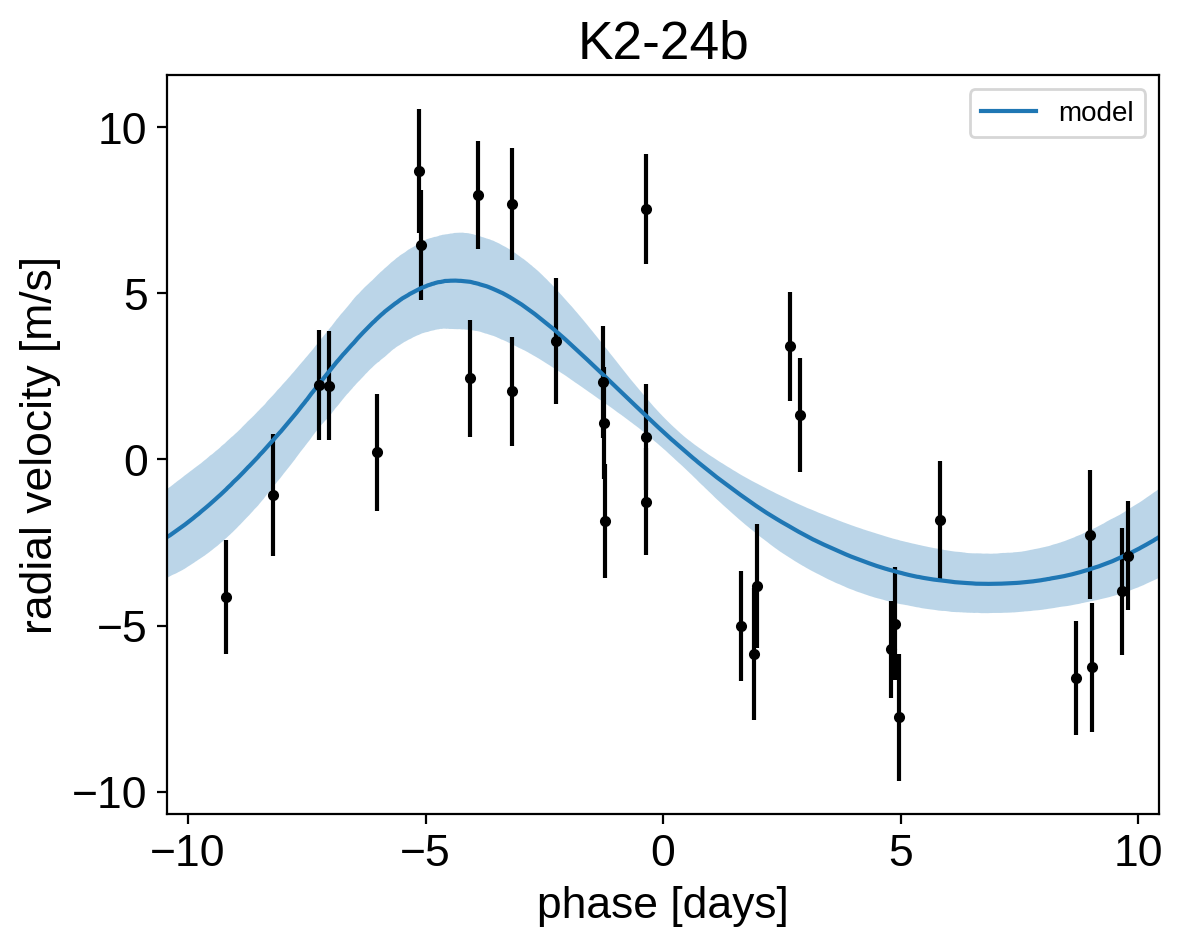

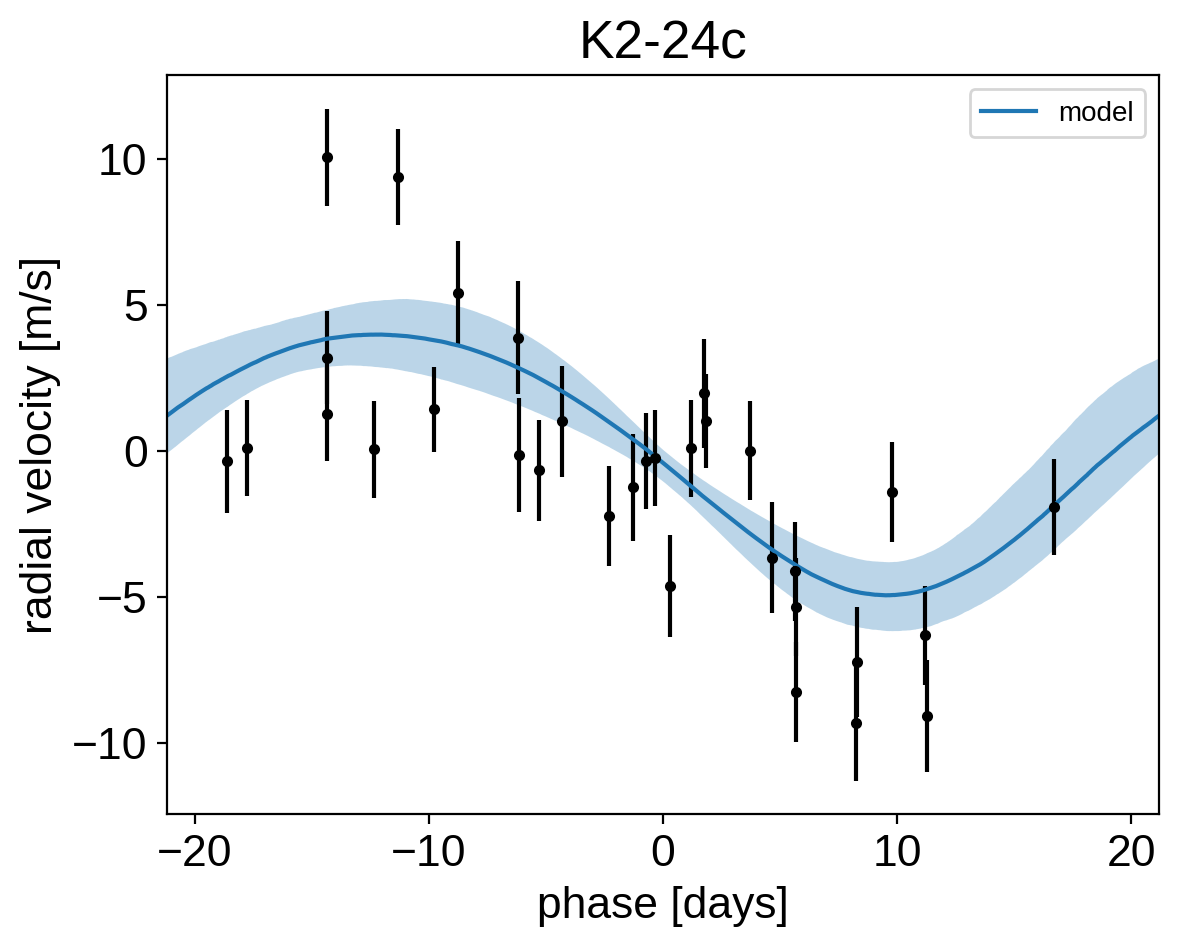

In [13]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter))

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [15]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
